# MI estimation 
between Flownet2, PWC-Net and PDD-Net

In [2]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm.notebook import tqdm, trange, tnrange
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import pandas as pd
import datetime as datetime
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp
from utils.encoding import labelMatrixOneHot, dice_coeff

from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f3410025490>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [3]:
class OBELISK2d(nn.Module):
    def __init__(self, chan=16, size=(150,150)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False,
                                groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False,
                                padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

        H = size[0]
        W = size[1]
        self.o_m = H // 4 +1
        self.o_n = W // 4 +1

        self.displace_range = 11
        self.disp_hw = 5
        self.ogrid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),(1, 1, self.o_m, self.o_n)).view(1, 1, -1, 2)#.cuda()
        self.disp_range = 0.25
        self.displacement_width = 11
        shift_xy = F.affine_grid(self.disp_range * torch.eye(2, 3).unsqueeze(0), (1, 1, self.displacement_width, self.displacement_width)).view(1, 1, -1, 2)#.cuda()
        grid_size = 32  # 25#30
        self.grid_xy = F.affine_grid(torch.eye(2, 3).unsqueeze(0),(1, 1, grid_size, grid_size)).view(1, -1, 1,2)#.cuda()

    def forward(self, fixed_img, moving_img):
        img_in_f = F.avg_pool2d(fixed_img, 3, padding=1, stride=2)
        img_in_f = F.relu(self.batch0(self.layer0(img_in_f)))
        sampled_f = F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_f -= F.grid_sample(img_in_f,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_1 = F.relu(self.batch1(self.layer1(sampled_f)))
        x_1 = F.relu(self.batch2(self.layer2(x_1)))
        features_fixed = self.layer3(x_1)
        
        img_in_m = F.avg_pool2d(moving_img, 3, padding=1, stride=2)
        img_in_m = F.relu(self.batch0(self.layer0(img_in_m)))
        sampled_m = F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[0, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)
        sampled_m -= F.grid_sample(img_in_m,self.ogrid_xy + self.offsets[1, :, :].view(1, -1,1,2)).view(1, -1, self.o_m, self.o_n)

        x_2 = F.relu(self.batch1(self.layer1(sampled_m)))
        x_2 = F.relu(self.batch2(self.layer2(x_2)))
        features_moving = self.layer3(x_2)

        ssd_distance = self.correlation_layer(features_moving, features_fixed)
        soft_cost,disp_xy = self.meanfield(ssd_distance, fixed_img, self.displace_range, self.o_m, self.o_n)
        
        return soft_cost, disp_xy


    def min_convolution(self, ssd_distance, displace_range, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5, stride=1)
        max1 = nn.MaxPool2d(3, stride=1)
        pad2 = nn.ReplicationPad2d(4)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(
            ssd_distance.permute(0, 2, 3, 1).reshape(1, -1, self.displace_range,
                                                    self.displace_range)))))

        ssd_minconv = ssd_minconv.permute(0, 2, 3, 1).view(1, -1, H, W)
        min_conv_cost = avg1(avg1(pad2(ssd_minconv)))

        return min_conv_cost


    def meanfield(self, ssd_distance, img_fixed, displace_range, H, W):
        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, displace_range, H, W)

        soft_cost = F.softmax(-10 * cost.view(displace_range ** 2, -1).t(), 1)

        disp_hw = (displace_range - 1) // 2
        disp_mesh_grid = disp_hw * F.affine_grid(torch.eye(2, 3).unsqueeze(0), (
        1, 1, displace_range, displace_range), align_corners=True)
        disp_mesh_grid /= torch.Tensor([(W - 1) * .5, (H - 1) * .5])

        disp_xy = torch.sum(
            soft_cost.view(1, H, W, -1, 1) * disp_mesh_grid.view(1, 1, 1, -1,
                                                                2).to(crnt_dev),
            3).permute(0, 3, 1, 2)

        return soft_cost, disp_xy


    def correlation_layer(self, feat_moving, feat_fixed):
        disp_hw = (self.displacement_width - 1) // 2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1, 0),
                                    (self.displace_range, self.displace_range),
                                    padding=self.disp_hw)
        B, C, H, W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold - feat_fixed.view(C, 1, -1)) ** 2).sum(0).view(1, self.displace_range ** 2, H, W)

        return ssd_distance

In [4]:
# load model that was trained with KD
path_to_state_dict = "models/Experiment_2/obel_16_KD_WL_20_01_22-12-54.pth"
model= OBELISK2d(16)
model.load_state_dict(torch.load(path_to_state_dict))
model.eval()#.cuda()

OBELISK2d(
  (layer0): Conv2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [5]:
flownet = load_flownet2().cuda()
flownet.eval()
pwc = load_pwcnet().cuda()
pwc.eval()

PWCDCNet(
  (conv1a): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1aa): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv1b): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2a): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2aa): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv2b): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
  )
  (conv3a): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)

In [6]:
imgs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_frames_disp_6.pth')
segs2 = torch.load('/share/data_ultraschall/nicke_ma/data/train_segs_disp_6.pth')

#imgs3 = torch.load('/share/data_ultraschall/nicke_ma/data/frames_oneFixed_multipleMoving.pth')
#segs3 = torch.load('/share/data_ultraschall/nicke_ma/data/segs_oneFixed_multipleMoving.pth')

#imgs = torch.cat((imgs2,imgs3))
#segs = torch.cat((segs2,segs3))

In [7]:
# function to calculate the angle of rotation per pixel
def get_rho(def_x):
    x = def_x.squeeze().numpy()[0,:,:]
    y = def_x.squeeze().numpy()[1,:,:]
    #show flow map for numpy
    H, W = x.shape
    rho = np.sqrt(x*x+y*y)
    theta = np.arctan2(x,-y)
    theta2 = (-theta+np.pi)/(2.0*np.pi);
    rho = np.clip(rho/np.percentile(rho, 99),0,1)
    return theta2

In [8]:
def get_angles(fixed, moving):
    """
    return angles of flow fields for image pair
    """
    
    # prepare for teachers
    flow_fixed = F.interpolate(fixed.unsqueeze(0).unsqueeze(0), size=(2*64,2*64), mode='bilinear')
    flow_moving =F.interpolate(moving.unsqueeze(0).unsqueeze(0), size=(2*64,2*64), mode='bilinear')

    # Pre processing step
    flow_in = preprocessing_flownet(flow_fixed.clone().reshape(2*64,2*64,1),flow_moving.clone().reshape(2*64,2*64,1))
    pwc_in = preprocessing_pwc(flow_fixed.clone().reshape(2*64,2*64,1),flow_moving.clone().reshape(2*64,2*64,1))
    
    # flownet2 inference
    flow_flow = flownet(flow_in.cuda()).cpu().detach() * 20
    flow_flow = flow_flow[0]

    # pwc inference
    pwc_flow = pwc(pwc_in.cuda()).cpu().detach() * 20
    pwc_flow = F.interpolate(pwc_flow, size=(128,128), mode='bilinear').squeeze()
    
    # PDD inference
    soft, disp_xy = model(fixed.cpu().unsqueeze(0).unsqueeze(0),moving.cpu().unsqueeze(0).unsqueeze(0))
    disp_xy = F.interpolate(disp_xy.cpu(), size=(128,128), mode='bilinear')
    
    # get the angles of rotation per pixel
    pwc_angle = get_rho(pwc_flow)
    pdd_angle = get_rho(disp_xy.detach())
    flow_angle = get_rho(flow_flow)
    
    return pwc_angle, flow_angle, pdd_angle

Image Loop:   0%|          | 0/1090 [00:00<?, ?it/s]

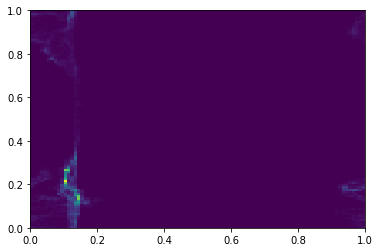

In [9]:
pdd_pwc_hists = []
pdd_flow_hists = []
flow_pwc_hists = []

x_bins = np.arange(0,1.01, 0.01)
y_bins = np.arange(0,1.01, 0.01)
num_bins = 100
# len(imgs)
for i in trange(len(imgs2), desc='Image Loop', leave=False):
    
    pwc_angle, flow_angle, pdd_angle = get_angles(torch.clone(imgs2[i][0]).float(), torch.clone(imgs2[i][1].float()))
    
    
    hist1, binsx, binsy, mesh = plt.hist2d(pwc_angle.ravel(), pdd_angle.ravel(), bins=[x_bins,y_bins], density=True)
    hist2, binsx, binsy, mesh = plt.hist2d(flow_angle.ravel(), pdd_angle.ravel(), bins=[x_bins,y_bins], density=True)
    hist3, binsx, binsy, mesh = plt.hist2d(flow_angle.ravel(), pwc_angle.ravel(), bins=[x_bins,y_bins], density=True)
    
    pdd_pwc_hists.append(hist1)
    pdd_flow_hists.append(hist2)
    flow_pwc_hists.append(hist3)


findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.


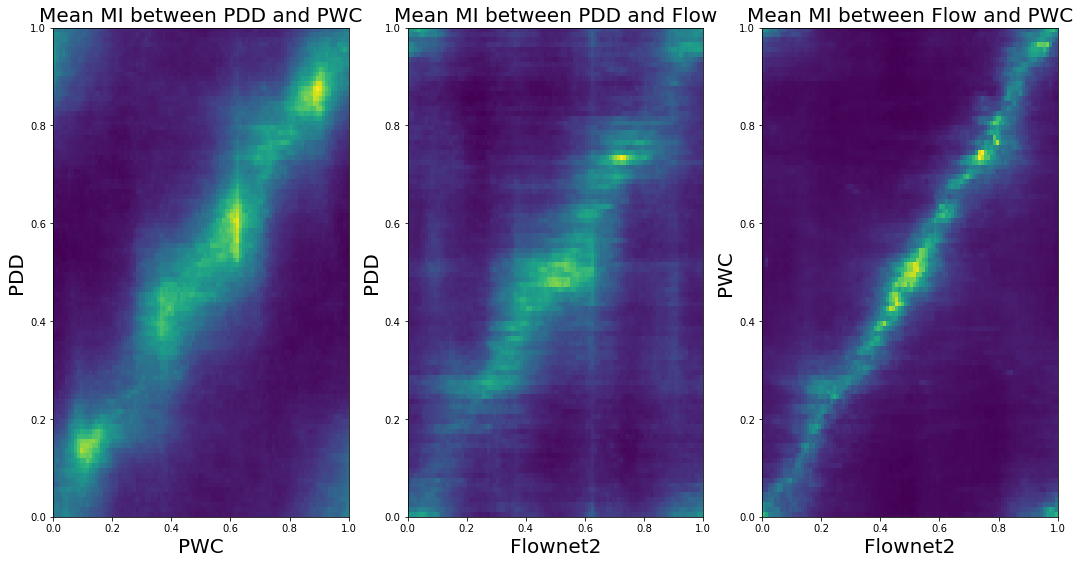

In [11]:
fonts = {'fontsize': 20,'family': 'Latin Modern Roman'}
fig, ax = plt.subplots(1,3, figsize=(18,9))

ax[0].set_title('Mean MI between PDD and PWC', fontdict=fonts)
ax[0].set_ylabel('PDD', fontdict=fonts)
ax[0].set_xlabel('PWC', fontdict=fonts)
ax[0].pcolormesh(x_bins, y_bins, np.array(pdd_pwc_hists).mean(axis=0))

ax[1].set_title('Mean MI between PDD and Flow', fontdict=fonts)
ax[1].set_ylabel('PDD', fontdict=fonts)
ax[1].set_xlabel('Flownet2', fontdict=fonts)
ax[1].pcolormesh(x_bins, y_bins, np.array(pdd_flow_hists).mean(axis=0))

ax[2].set_title('Mean MI between Flow and PWC', fontdict=fonts)
ax[2].set_xlabel('Flownet2', fontdict=fonts)
ax[2].set_ylabel('PWC', fontdict=fonts)
ax[2].pcolormesh(x_bins, y_bins, np.array(flow_pwc_hists).mean(axis=0))

plt.show()

Dann war das ganze doch recht aufschlussreich, wir wissen jetzt dass das Flownet einfach nicht viel tut (ob weil es auf die Daten so trainiert ist oder weil es dazu neigt idk)

Und dass das Pdd von beiden Teachs lernt.